In [1]:
# Recurrent Neural Network

#https://www.youtube.com/watch?v=zwqwlR48ztQ

# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('./marketdata/zsh20.csv')
#dataset_train = dataset_train[dataset_train["Volume"] != 0]

dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
dataset_train.set_index('Time', inplace=True)
dataset_train.shape

(490, 7)

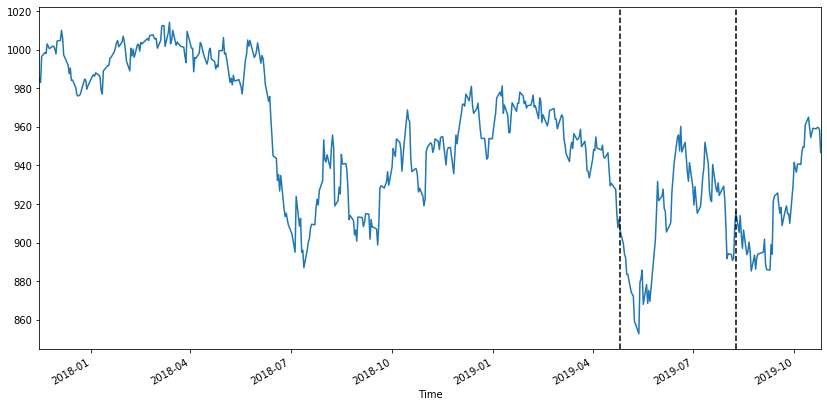

In [2]:
ax = dataset_train["Last"].plot(figsize=(14, 7))
ax.axvline("26-04-2019", linestyle="--", c="black")
ax.axvline("08-09-2019", linestyle="--", c="black")

In [ ]:
df_train = dataset_train[dataset_train.index < "26-04-2019"]
df_train.shape

In [ ]:
df_val = dataset_train[(dataset_train.index >= "26-04-2019") & (dataset_train.index < "08-09-2019")]
df_val.shape

In [ ]:
dataset_train.head()

In [3]:
training_set = dataset_train.iloc[:, 3:4].values
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [4]:
# Creating a data structure with 15 timesteps and 1 output - we use last 15 prices to predict next. 
#This takes data from 15th row onwards
X_whole = []
y_whole = []
sequence_size = 3
for i in range(sequence_size, len(training_set_scaled)):
    X_whole = np.append(X_whole, training_set_scaled[i-sequence_size:i, 0])
    y_whole.append(training_set_scaled[i, 0])

sz = training_set_scaled.shape[0]-sequence_size
X_whole, y_whole = np.array(X_whole.reshape(sz,sequence_size)), np.array(y_whole)

In [5]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

In [ ]:
X_test.shape

In [6]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [7]:
%%time
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
#regressor.add(LSTM(units = 15, return_sequences = True))
#regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compiling the RNN
regressor.compile(optimizer = adm, loss = 'mean_squared_error' , metrics=["mean_squared_error"])

# Fitting the RNN to the Training set
hist = regressor.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs = 100, batch_size = 8, verbose=0)

Using TensorFlow backend.


Wall time: 22.2 s


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


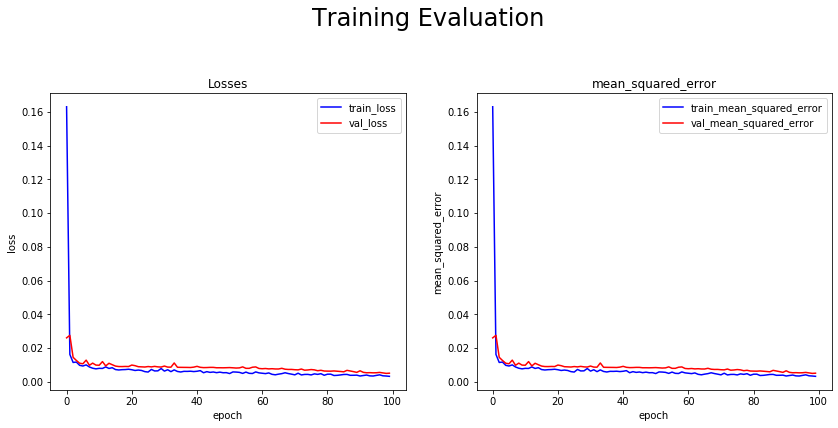

In [8]:
plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

In [11]:
#create empty table with 6 fields to inverse
real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
real_stock_price.shape

(67, 1)

sqrt mean_squared_error:  8.574831916041635
mean_squared_error:  73.52774238836626
mean_absolute_error:  6.385846949335341


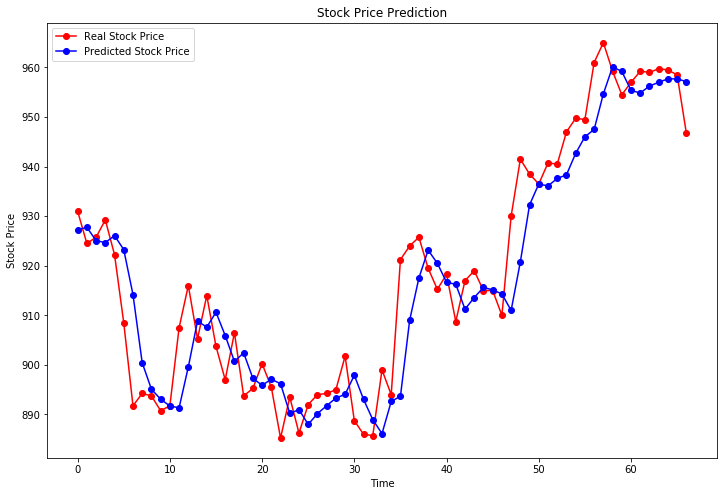

In [12]:
# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
# create empty table with 6 fields to inverse
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[902.30596924 901.15875244 900.37896729 900.08300781 899.5390625
 899.05163574 898.59552002 898.13604736 897.69207764 897.26013184
 896.83874512 896.42877197 896.02960205 895.64129639 895.26348877
 894.89599609 894.53869629 894.19134521 893.85369873 893.52575684
 893.20709229 892.89758301 892.5970459  892.30523682 892.02197266
 891.74713135 891.48046875 891.22167969 890.97076416 890.72735596
 890.49145508 890.26263428 890.04095459 889.82598877 889.61773682
 889.41601562 889.22052002 889.03125    888.84790039 888.67028809
 888.49841309 888.33203125 888.17095947 888.01501465 887.86419678
 887.71820068 887.57696533 887.44024658 887.30804443 887.18017578
 887.05651855 886.93682861 886.82116699 886.70935059 886.60125732
 886.49664307 886.39562988 886.2979126  886.20349121 886.11224365
 886.02398682 885.93878174 885.85638428 885.77685547 885.69989014
 885.62561035 885.55383301]
sqrt mean_squared_error:  38.683013020750046
mean_squared_error:  1496.3754963635174
mean_absolute_error:  29.12478

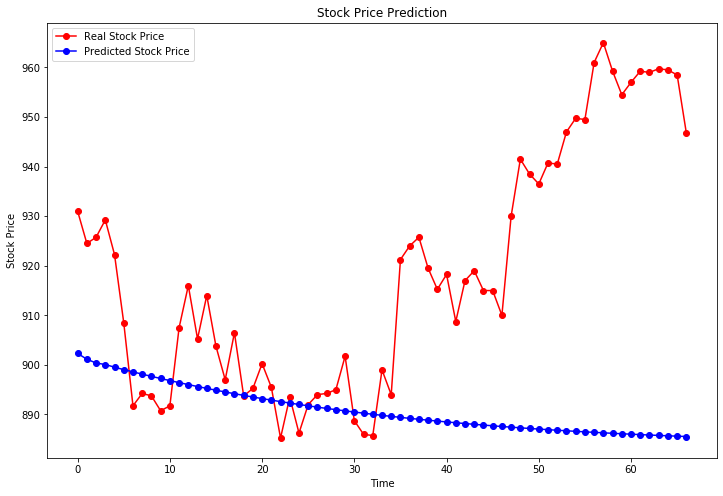

In [14]:
#predicting on new data
xw=X_train[-1,:].copy()
xw=xw.reshape(1,-1)
xw=np.reshape(xw,(xw.shape[0], xw.shape[1], 1))

y_pred_w = []

num_of_pred = real_stock_price.shape[0]

for i in range(0,num_of_pred):
    
    y_pred1=regressor.predict(xw)
    y_transformed  = sc.inverse_transform(y_pred1)
    y_pred_w = np.append(y_pred_w,y_transformed)
    
    #print("Before", xw)
#    print(xwvap)
#    print(xvchange)
    #print(y_pred1)
    
    if sequence_size>1:
        for j in range(sequence_size-1):
            xw[:,j]=xw[:,j+1]
        
    xw[:,sequence_size-1]=y_pred1

    #print("After",xw)
#    print(xwvap)
#    print(xvchange)
    
print(y_pred_w)
predicted_stock_price = y_pred_w
predicted_stock_price.shape[0]


from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
import plotly.express as px

# Getting the real stock price 
# Importing the training set
dataset_train = pd.read_csv('./marketdata/zsh20.csv')
#dataset_train = dataset_train[dataset_train["Volume"] != 0]
training_set = dataset_train.iloc[:, 4:5].values
real_stock_price = dataset_train.iloc[422:, 4:5].values

prices = pd.DataFrame(real_stock_price, columns=["prices"])
prices["Time"] = dataset_train["Time"].iloc[422:].values
prices['data'] = 'real_stock_price'

prices1 = pd.DataFrame(predicted_stock_price, columns=["prices"])
prices1["Time"] = dataset_train["Time"].iloc[422:].values
prices1['data'] = 'predicted_stock_price'
prices1.fillna("10/26/2019", inplace=True)

prices = prices.append(prices1, ignore_index=True)

fig = px.line(prices, x="Time", y="prices", line_dash="data")
fig.show()

## lightgbm

Training and making predictions
sqrt mean_squared_error:  9.995916381395979
mean_squared_error:  99.91834430386048
mean_absolute_error:  8.163658192740373


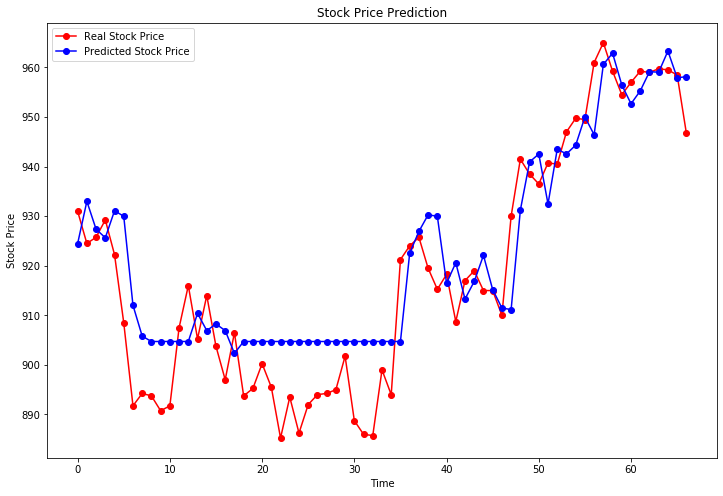

In [16]:
import lightgbm as lgb
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2)))


print('Training and making predictions')
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
    'metric': 'rmsle'}

n_estimators = 60

n_iters = 5
preds_buf = []
err_buf = []

#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)
watchlist = [d_valid]

model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)
predicted_stock_price = model.predict(X_test)

#create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(y_test), 6) )
test_data[:,2] = y_test
real_stock_price = sc.inverse_transform(test_data)[:,2]

# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
# create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(predicted_stock_price), 6) )
test_data[:,2] = predicted_stock_price.reshape(1,-1)
predicted_stock_price = sc.inverse_transform(test_data)[:,2]

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)
fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## RandomForest

0.9925523407636846 0.8375210667836481
0.06054201764668321
sqrt mean_squared_error:  9.777535849939337
mean_squared_error:  95.60020729684895
mean_absolute_error:  7.966791044776119


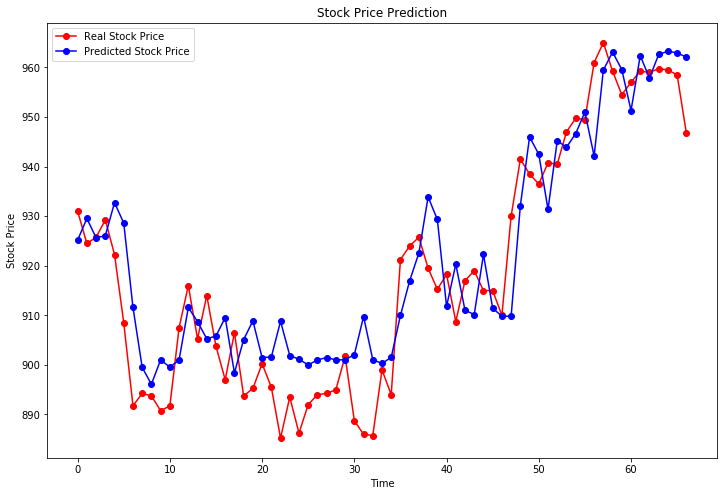

In [18]:
from sklearn.metrics import mean_squared_error as MSE

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=60)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))
print(np.sqrt(MSE(y_test, rf.predict(X_test))))
predicted_stock_price = rf.predict(X_test)
#create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(y_test), 6) )
test_data[:,2] = y_test
real_stock_price = sc.inverse_transform(test_data)[:,2]

# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
# create empty table with 6 fields to inverse
test_data = np.zeros(shape=(len(predicted_stock_price), 6) )
test_data[:,2] = predicted_stock_price.reshape(1,-1)
predicted_stock_price = sc.inverse_transform(test_data)[:,2]

#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
print(gb.score(X_train, y_train), gb.score(X_test, y_test))
print(np.sqrt(MSE(y_test, gb.predict(X_test))))

preds = gb.predict(X_test)
# Part 3 - Making the predictions and visualising the results
predicted_stock_price = sc.inverse_transform(preds.reshape(-1, 1))

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## XGBoost

[03:36:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.975997958900825 0.8521904554834743
0.057744363711031275
mean_absolute_error:  7.411703992245799


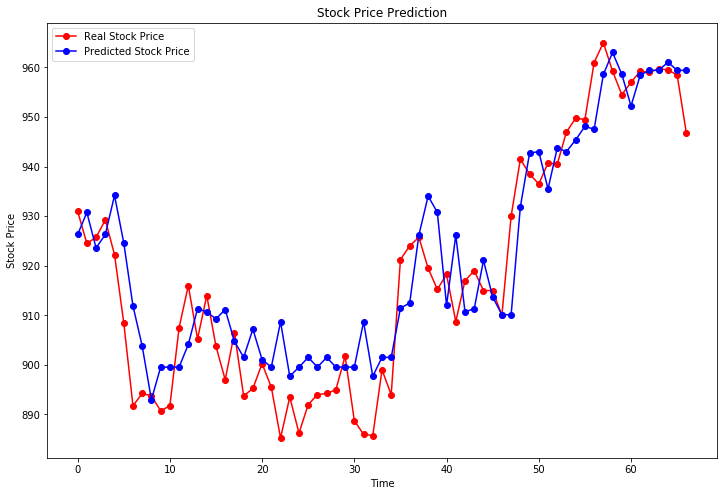

In [19]:
from xgboost.sklearn import XGBRegressor
reg=XGBRegressor(learning_rate=0.1, n_estimators=60, n_jobs=1)
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train), reg.score(X_test, y_test))
print(np.sqrt(MSE(y_test, reg.predict(X_test))))
preds = reg.predict(X_test)

# Part 3 - Making the predictions and visualising the results
predicted_stock_price = sc.inverse_transform(preds.reshape(-1, 1))

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301 885.55383301 885.55383301 885.55383301
 885.55383301 885.55383301]
sqrt mean_squared_error:  41.111105939608755
mean_squared_error:  1690.1230315777345
mean_absolute_error:  33.2015

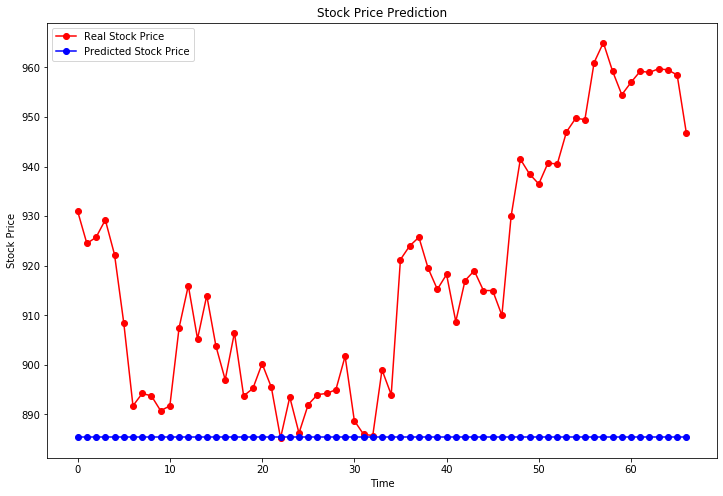

In [27]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()

#predicting on new data
xw=X_valid[-1,:].copy()
xw=xw.reshape(1,-1)
#xw=np.reshape(xw,(xw.shape[0], xw.shape[1], 1))

y_pred_w = []

num_of_pred = X_test.shape[0]

for i in range(0,num_of_pred):
    
    preds = reg.predict(xw)

    # Part 3 - Making the predictions and visualising the results
    predicted_stock_price = sc.inverse_transform(preds.reshape(-1, 1))
    y_pred_w = np.append(y_pred_w,y_transformed)
    
    #print("Before", xw)
#    print(xwvap)
#    print(xvchange)
    #print(y_pred1)
    
    if sequence_size>1:
        for j in range(sequence_size-1):
            xw[:,j]=xw[:,j+1]
        
    xw[:,sequence_size-1]=y_pred1

    #print("After",xw)
#    print(xwvap)
#    print(xvchange)
    
print(y_pred_w)
predicted_stock_price = y_pred_w
predicted_stock_price.shape[0]


from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))
print("mean_squared_error: ", mean_squared_error(real_stock_price, predicted_stock_price))
mean_absolute_error = mean_absolute_error(real_stock_price, predicted_stock_price)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(real_stock_price, color = 'red',  marker='o', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue',  marker='o', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
